# Analysis of Chicago Property Value and Green Space (NDVI) in Chicago


- Used data mining and machine learning techniques to examine the relationship between property value and green space in Chicago. 
- Found that the two were negatively correlated, but this is due to the highly dense Chicago downtown area
- In a future iteration of this project, the downtown outlier would be accounted for

## Setting Up the Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

from scipy.optimize import minimize

In [2]:
pops = pd.read_csv("Chicago_Population_Counts.csv")
pops = pops.drop(labels=[0,60], axis=0)
#pops.loc[pops.Geography=='Chicago']

In [3]:
pops.Geography = pd.to_numeric(pops.Geography)
pop1 = pops[['Geography', 'Population - Total']]
len(pop1)

118

In [4]:
cook = pd.read_csv("combined_price_zip.csv")
cook.columns = cook.columns.str.replace(' ', '_')
cook.rename({"mean": "mean_ndvi"}, axis='columns', inplace=True)

In [5]:
df = cook.merge(pop1, left_on='Property_Zip_Code', right_on='Geography').drop_duplicates(subset=['Property_Zip_Code'])
df = df.reset_index()
df.columns

Index(['index', 'Unnamed:_0', 'Property_Zip_Code', 'Sale_Price', 'mean_ndvi',
       'AWATER10', 'ALAND10', 'FUNCSTAT10', 'INTPTLON10', 'CLASSFP10',
       'ZCTA5CE10', 'MTFCC10', 'INTPTLAT10', 'system:index', 'GEOID10',
       'Geography', 'Population - Total'],
      dtype='object')

In [6]:
df = df.rename(columns={"Population - Total": "pop_total"})
len(df)

54

In [7]:
df.columns

Index(['index', 'Unnamed:_0', 'Property_Zip_Code', 'Sale_Price', 'mean_ndvi',
       'AWATER10', 'ALAND10', 'FUNCSTAT10', 'INTPTLON10', 'CLASSFP10',
       'ZCTA5CE10', 'MTFCC10', 'INTPTLAT10', 'system:index', 'GEOID10',
       'Geography', 'pop_total'],
      dtype='object')

## Standardizing Property Values and Mean NDVI Values

- The NDVI values are normally distributed, but the property values are skewed 
- Apply a Box Cox transformation (log) on these values to normalize them.

In [8]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x,ddof=1)  

def correlation(x, y):
    x_in_standard_units = standard_units(x)
    y_in_standard_units = standard_units(y)
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return sum(x_in_standard_units * y_in_standard_units)/(len(x)-1)

In [9]:
cook.head(2)

,Unnamed:_0,Property_Zip_Code,Sale_Price,mean_ndvi,AWATER10,ALAND10,FUNCSTAT10,INTPTLON10,CLASSFP10,ZCTA5CE10,MTFCC10,INTPTLAT10,system:index,GEOID10
0,0,60605,7.538358e+05,0.126884,2031071,3225725,S,-87.617228,B5,60605,G6350,41.867566,00040000000000001876,60605
1,1,60606,2.250000e+06,0.074290,0,661666,S,-87.637349,B5,60606,G6350,41.882066,000400000000000005f8,60606


In [10]:
#cook["sqrt_ndvi"] = cook.mean_ndvi ** 0.5
#cook["sqrt_sale"] = cook.Sale_Price ** 0.5
cook["log_sale"] = np.log(cook.Sale_Price)

In [11]:
cook.head(2)

,Unnamed:_0,Property_Zip_Code,Sale_Price,mean_ndvi,AWATER10,ALAND10,FUNCSTAT10,INTPTLON10,CLASSFP10,ZCTA5CE10,MTFCC10,INTPTLAT10,system:index,GEOID10,log_sale
0,0,60605,7.538358e+05,0.126884,2031071,3225725,S,-87.617228,B5,60605,G6350,41.867566,00040000000000001876,60605,13.532930
1,1,60606,2.250000e+06,0.074290,0,661666,S,-87.637349,B5,60606,G6350,41.882066,000400000000000005f8,60606,14.626441


In [12]:
std_sale = standard_units(cook.log_sale)
#std_sale = standard_units(cook.sqrt_sale)
std_ndvi = standard_units(cook.mean_ndvi)

In [13]:
cook["std_sale_price"] = std_sale
cook["std_ndvi"] = std_ndvi

In [14]:
geom_mult = (cook.std_sale_price * cook.std_ndvi)

In [15]:
cook["geom_mult"] = geom_mult

In [16]:
cook["geom_mean"] = np.sqrt(np.abs(geom_mult))

## Combine All Calculated Values Into One Table

- Calculated a geometric mean to average property value and green space in Chicago
- Simplified, the geometric mean = sqrt(sale * green space)
- The column "geom_mean" contains these values


In [17]:
cook.head(5)

,Unnamed:_0,Property_Zip_Code,Sale_Price,mean_ndvi,AWATER10,ALAND10,FUNCSTAT10,INTPTLON10,CLASSFP10,ZCTA5CE10,MTFCC10,INTPTLAT10,system:index,GEOID10,log_sale,std_sale_price,std_ndvi,geom_mult,geom_mean
0,0,60605,7.538358e+05,0.126884,2031071,3225725,S,-87.617228,B5,60605,G6350,41.867566,00040000000000001876,60605,13.532930,0.860981,-1.192796,-1.026975,1.013398
1,1,60606,2.250000e+06,0.074290,0,661666,S,-87.637349,B5,60606,G6350,41.882066,000400000000000005f8,60606,14.626441,2.150924,-1.710807,-3.679816,1.918285
2,2,60607,8.452913e+05,0.132765,0,6009736,S,-87.651596,B5,60607,G6350,41.874932,000400000000000005f9,60607,13.647437,0.996057,-1.134869,-1.130395,1.063200
3,3,60608,3.946474e+05,0.165517,456919,16452029,S,-87.672388,B5,60608,G6350,41.846223,00040000000000001877,60608,12.885748,0.097543,-0.812284,-0.079233,0.281484
4,4,60609,2.131057e+05,0.221666,49424,20092663,S,-87.656935,B5,60609,G6350,41.812680,00040000000000001878,60609,12.269544,-0.629352,-0.259259,0.163165,0.403937


In [18]:
#cook.to_csv('out.csv', index=False)

In [19]:
np.max(cook.geom_mean), np.min(cook.geom_mean)

(2.1055825647471704, 0.06229101711506454)

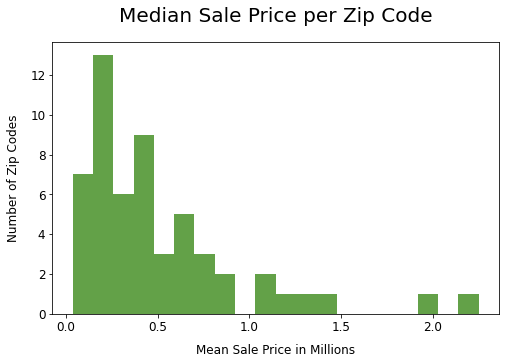

In [42]:
plt.figure(figsize=(8,5))

plt.hist(cook.Sale_Price/1e6, bins=20, color="#63a148")
plt.title("Median Sale Price per Zip Code", pad=20, fontsize=20)
plt.xlabel("Mean Sale Price in Millions", labelpad=10)
plt.ylabel("Number of Zip Codes", labelpad=10)

plt.rcParams.update({'font.size': 16})
#plt.savefig("hist_sale_price.png", bbox_inches="tight")
print()

# not normally distributed

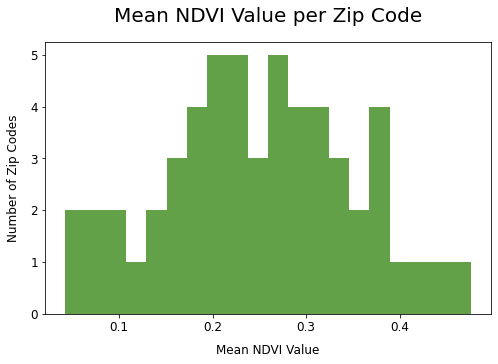

In [41]:
plt.figure(figsize=(8,5))

plt.hist(cook.mean_ndvi, bins=20, color="#63a148")
plt.title("Mean NDVI Value per Zip Code", pad=20, fontsize=20)
plt.xlabel("Mean NDVI Value", labelpad=10)
plt.ylabel("Number of Zip Codes", labelpad=10)

plt.rcParams.update({'font.size': 12})
# plt.savefig("hist_ndvi.png", bbox_inches="tight")

print()

# mean ndvi was already roughly normally distributed, no transformation needed

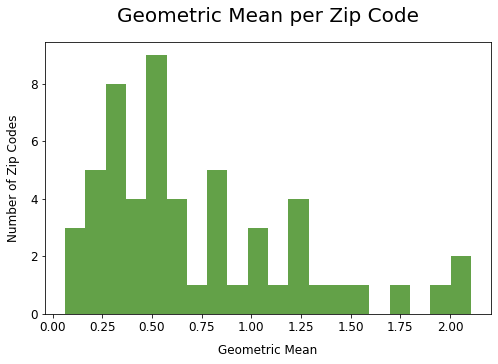

In [40]:
plt.figure(figsize=(8,5))

plt.hist(cook.geom_mean, bins=20, color="#63a148")
plt.title("Geometric Mean per Zip Code", pad=20, fontsize=20)
plt.xlabel("Geometric Mean", labelpad=10)
plt.ylabel("Number of Zip Codes", labelpad=10)


plt.rcParams.update({'font.size': 12})
#plt.savefig("hist_geom_mean.png", bbox_inches="tight")

print()

# geometric mean of standardized sale price and ndvi values

# i think it's skewed based on what we found with the scatter plots earlier; in a lot of zip codes, 
# NDVI and property value are inversely related 

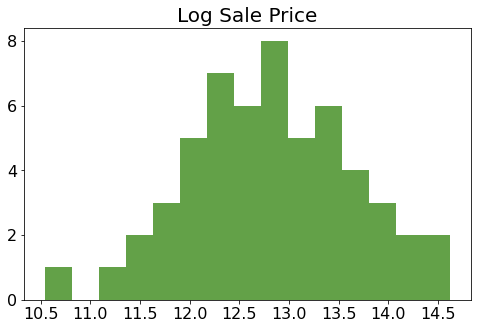

In [43]:
plt.figure(figsize=(8,5))

plt.hist(cook.log_sale, bins=15, color="#63a148")
plt.title("Log Sale Price", fontsize=20)


print()

# sale price values have been log-transformed to fit the normal distribution

# performed boxcox on the values
# boxcox confidence interval included 0 --> log transformation


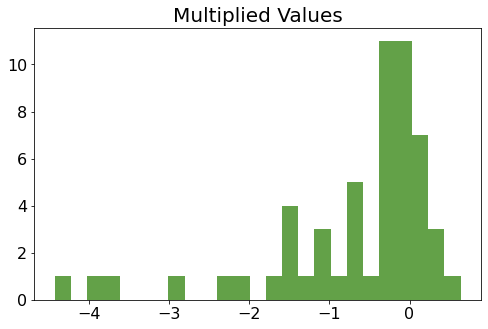

In [44]:
plt.figure(figsize=(8,5))

plt.hist(cook.geom_mult, bins=25, color="#63a148")
plt.title("Multiplied Values", fontsize=20)

print()

# multiplied standardized sale price and ndvi values
# interesting; some combination of lower-than-average NDVI/sale-price yields negative values

## Quantile plots of property value and mean NDVI (just to check for normality)

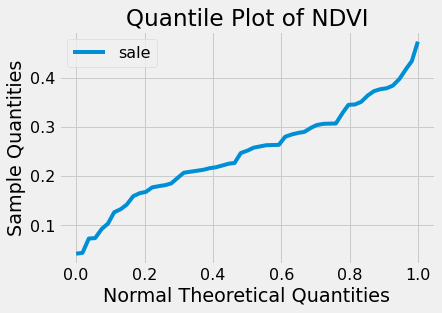

In [25]:
xfine= np.arange(0,1,.001)
quant_ndvi = np.quantile(cook.mean_ndvi,xfine)
#quant_ndvi = np.quantile(cook.mean_ndvi, xfine)

fig, ax = plt.subplots()

plt.plot(xfine, quant_ndvi, label="sale")
#plt.plot(xfine, quant_ndvi, label="ndvi")

plt.legend(loc='upper left')
plt.title("Quantile Plot of NDVI")
plt.xlabel("Normal Theoretical Quantities")
plt.ylabel("Sample Quantities")


plt.show()

# looks roughly normal

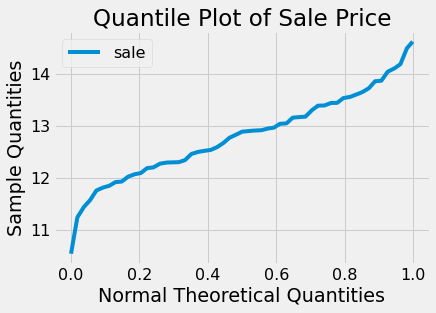

In [26]:
xfine= np.arange(0,1,.001)
quant_sale = np.quantile(cook.log_sale,xfine)
#quant_ndvi = np.quantile(cook.mean_ndvi, xfine)

fig, ax = plt.subplots()

plt.plot(xfine, quant_sale, label="sale")
#plt.plot(xfine, quant_ndvi, label="ndvi")

plt.legend(loc='upper left')
plt.title("Quantile Plot of Sale Price")
plt.xlabel("Normal Theoretical Quantities")
plt.ylabel("Sample Quantities")


plt.show()

# looks roughly normal although possibly heavy-tailed

# ————————————————————————

## Multiple Linear Regression 

**Used property value and population density as predictors (trying to take downtown area into account as an outlier)**

In [58]:
pop_dense = df.pop_total/df.ALAND10/1e6
     
df["pop_dense"] = pop_dense

In [59]:
def multi2(b):
    estimate = \
    b[0] \
    +b[1]*standard_units(df.Sale_Price) \
    +b[2]*standard_units(df.pop_dense) 
    
    return (np.mean((df.mean_ndvi - estimate) ** 2))

# to find the estimated values of the parameters
minimize(multi2,x0=[0,0,0],method="BFGS").x

array([ 0.24556814, -0.04291435, -0.0415828 ])

In [60]:
n=df.shape[0]

tmp_df=df

predicted = np.array([])
    
for i in range(n):
    # drop the i-th row (training using n-1 values)
    tmp_df=df.drop(i)

    tmp_fit=minimize(multi2,x0=[0,0,0],method="BFGS").x

    tmp_pred=tmp_fit[0] \
            +tmp_fit[1]*standard_units(df.Sale_Price)[i] \
            +tmp_fit[2]*standard_units(df.pop_dense)[i] \
    
    predicted = np.append(predicted, tmp_pred)

In [61]:
predicted[:5]

array([0.19381922, 0.09969702, 0.22873547, 0.27237102, 0.31056742])

In [62]:
df["mean_ndvi"][:5]

0    0.126884
1    0.074290
2    0.132765
3    0.165517
4    0.221666
Name: mean_ndvi, dtype: float64

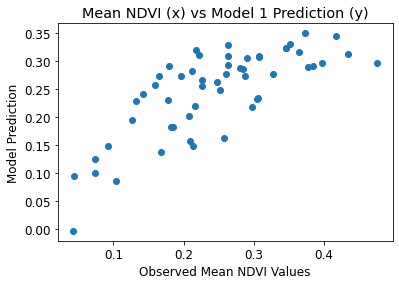

In [63]:
plt.rcParams.update({'font.size': 12})

plt.scatter(df["mean_ndvi"],predicted)
plt.xlabel("Observed Mean NDVI Values")
plt.ylabel("Model Prediction")
plt.title('Mean NDVI (x) vs Model 1 Prediction (y)')

print()

## Univariate Regression Plots
**sale price and population density vs green space**

In [64]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x,ddof=1)  

def correlation(x, y):
    x_in_standard_units = standard_units(x)
    y_in_standard_units = standard_units(y)
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return sum(x_in_standard_units * y_in_standard_units)/(len(x)-1)

In [65]:
std_sale = standard_units(cook.Sale_Price)
std_ndvi = standard_units(cook.mean_ndvi)


In [66]:
def regression(df, x, y):
    xcol = df[x]
    ycol = df[y]
    
    meanx = np.mean(xcol)
    meany = np.mean(ycol)
    
    stdx = np.std(xcol)
    stdy = np.std(ycol)
    
    numer = 0
    denom = 0
    
    for i in range(len(df)):
        numer += (xcol[i] - meanx) * (ycol[i] - meany)
        denom += (xcol[i] - meanx) ** 2

    slope = numer / denom
    intercept = meany - (slope * meanx)
    
    return "Slope:", slope, "Intercept:", intercept

In [67]:
cook.dtypes

Unnamed:_0             int64
Property_Zip_Code      int64
Sale_Price           float64
mean_ndvi            float64
AWATER10               int64
ALAND10                int64
FUNCSTAT10            object
INTPTLON10           float64
CLASSFP10             object
ZCTA5CE10              int64
MTFCC10               object
INTPTLAT10           float64
system:index          object
GEOID10                int64
log_sale             float64
std_sale_price       float64
std_ndvi             float64
geom_mult            float64
geom_mean            float64
dtype: object

In [68]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x,ddof=1)  

def correlation(x, y):
    x_in_standard_units = standard_units(x)
    y_in_standard_units = standard_units(y)
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return sum(x_in_standard_units * y_in_standard_units)/(len(x)-1)

In [69]:
correlation(cook.Sale_Price, cook.mean_ndvi)

-0.6908920826579283

In [70]:
regression(cook, "Sale_Price", "mean_ndvi")

('Slope:', -1.5395196920475398e-07, 'Intercept:', 0.3264814799558015)

In [71]:
len(cook.mean_ndvi)

55

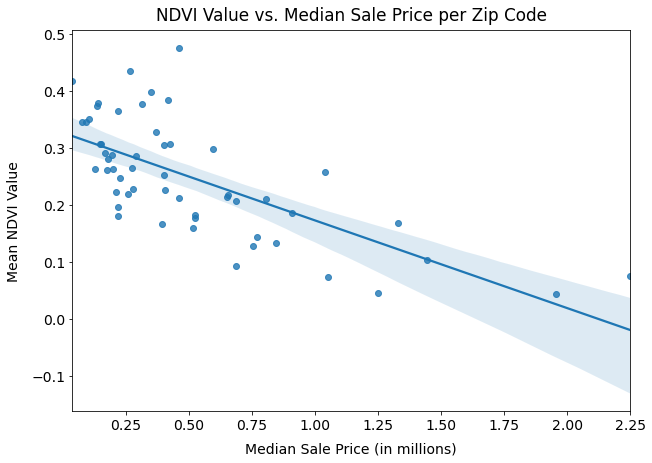

In [72]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})

sns.regplot(x=cook.Sale_Price/1e6, y=cook.mean_ndvi);
#sns.regplot(x="Sale_Price", y="mean_ndvi", data=cook);
plt.title("NDVI Value vs. Median Sale Price per Zip Code", pad=10)
plt.xlabel("Median Sale Price (in millions)", labelpad=10)
plt.ylabel("Mean NDVI Value", labelpad=10)

plt.rcParams.update({'font.size': 16})
plt.savefig("lin_reg_saleprice.png", bbox_inches="tight")



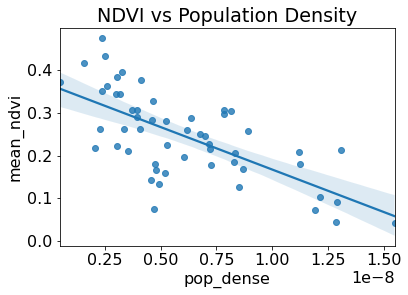

In [75]:

sns.regplot(x="pop_dense", y="mean_ndvi", data=df)
plt.title("NDVI vs Population Density")
print()

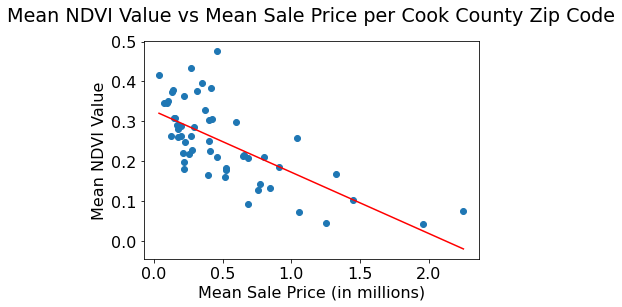

In [57]:

plt.scatter(cook.Sale_Price/1000000, cook.mean_ndvi)
x = np.linspace(np.min(cook["Sale_Price"])/1000000, np.max(cook["Sale_Price"])/1000000,60)
y = -0.1539*x + 0.326
plt.plot(x, y, '-r')

plt.title("Mean NDVI Value vs Mean Sale Price per Cook County Zip Code", pad=20)
plt.xlabel("Mean Sale Price (in millions)")
plt.ylabel("Mean NDVI Value")

print()

In [45]:
cook.iloc[np.where(cook.Sale_Price == cook.Sale_Price.min())]

,Unnamed:_0,Property_Zip_Code,Sale_Price,mean_ndvi,AWATER10,ALAND10,FUNCSTAT10,INTPTLON10,CLASSFP10,ZCTA5CE10,MTFCC10,INTPTLAT10,system:index,GEOID10,log_sale,std_sale_price,std_ndvi,geom_mult,geom_mean
54,54,60827,37728.0,0.416466,1229641,18161652,S,-87.633572,B5,60827,G6350,41.649434,00040000000000001981,60827,10.538158,-2.671753,1.659389,-4.433478,2.105583


In [44]:
cook.iloc[np.where(cook.Sale_Price == cook.Sale_Price.max())]

,Unnamed:_0,Property_Zip_Code,Sale_Price,mean_ndvi,AWATER10,ALAND10,FUNCSTAT10,INTPTLON10,CLASSFP10,ZCTA5CE10,MTFCC10,INTPTLAT10,system:index,GEOID10,log_sale,std_sale_price,std_ndvi,geom_mult,geom_mean
1,1,60606,2250000.0,0.07429,0,661666,S,-87.637349,B5,60606,G6350,41.882066,000400000000000005f8,60606,14.626441,2.150924,-1.710807,-3.679816,1.918285
